In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

from scipy import spatial


In [3]:
from aislens.utils import subset_dataset_by_time
from aislens.dataprep import detrend_dim
from aislens.dataprep import detrend_dim, deseasonalize, dedraft_catchment, extrapolate_catchment_over_time
from aislens.utils import merge_catchment_files, subset_dataset_by_time, collect_directories, initialize_directories, write_crs
from aislens.config import config
import numpy as np
import xarray as xr
import geopandas as gpd

model = xr.open_dataset(config.FILE_MPASO_MODEL, chunks={config.TIME_DIM: 36})
icems = gpd.read_file(config.FILE_ICESHELFMASKS);
model = write_crs(model, config.CRS_TARGET)

model_subset = subset_dataset_by_time(model,
                                          time_dim=config.TIME_DIM,
                                          start_year=config.SORRM_START_YEAR,
                                          end_year=config.SORRM_END_YEAR,
                                          )
model_detrended = model_subset.copy()

model_detrended = model_subset.copy()
model_detrended[config.SORRM_FLUX_VAR] = detrend_dim(model_subset[config.SORRM_FLUX_VAR], dim=config.TIME_DIM, deg=1)
model_seasonality = xr.open_dataset(config.FILE_SEASONALITY, chunks={config.TIME_DIM: 36})
model_variability = xr.open_dataset(config.FILE_VARIABILITY, chunks={config.TIME_DIM: 36})
icems = icems.to_crs({'init': config.CRS_TARGET});

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
model_seasonality_ts = model_seasonality.__xarray_dataarray_variable__.mean(["x", "y"]).compute()
model_variability_ts = model_variability.timeMonthly_avg_landIceFreshwaterFlux.mean(["x", "y"]).compute()

AttributeError: 'Dataset' object has no attribute '__xarray_dataarray_variable__'

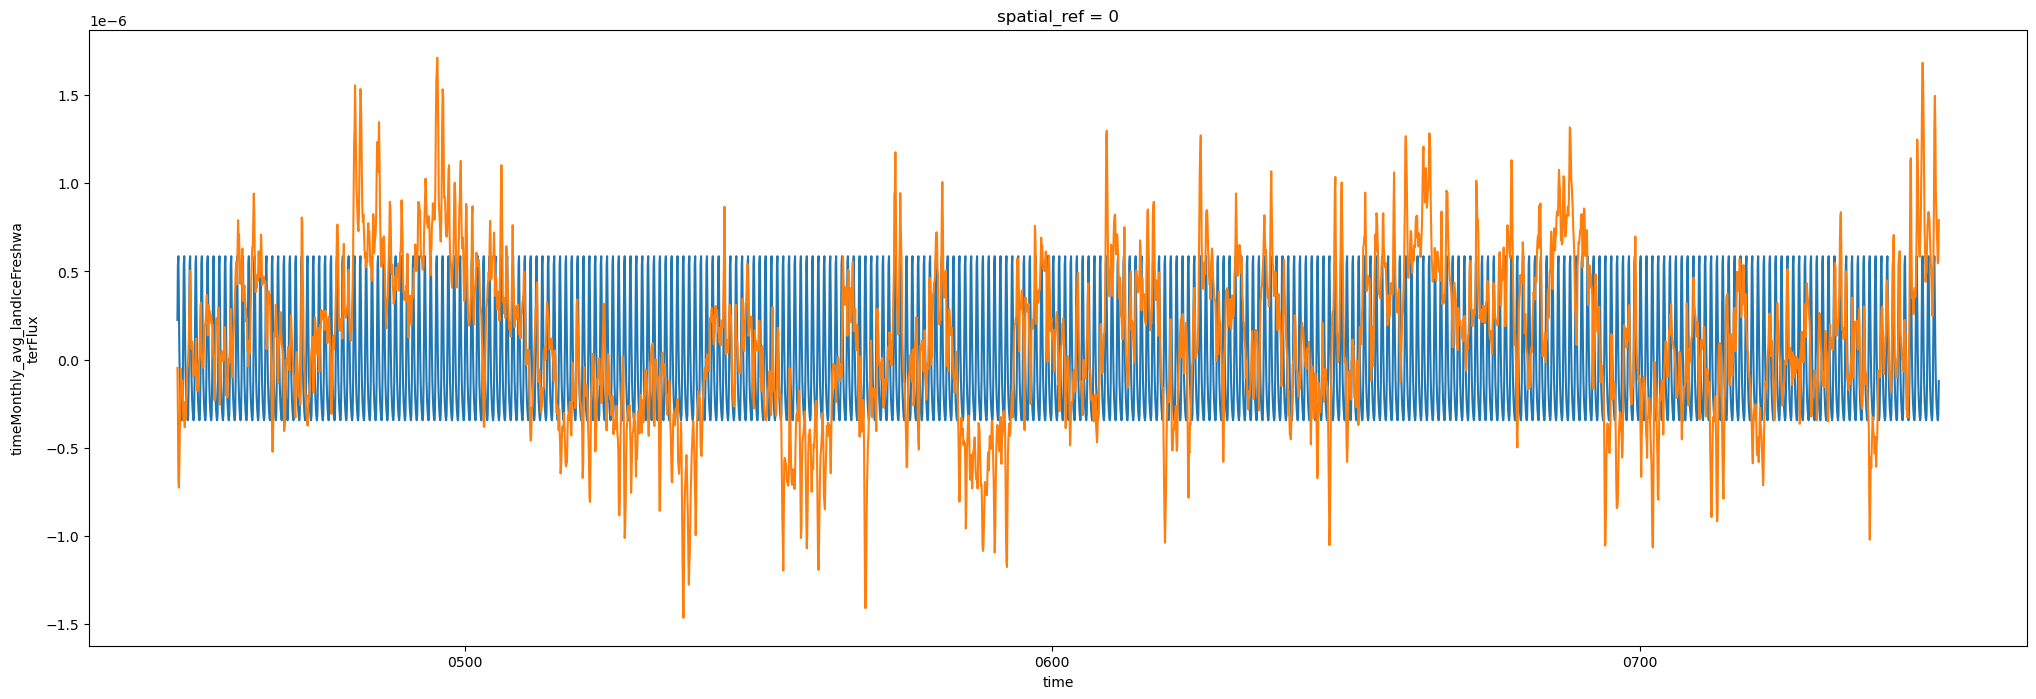

In [5]:
plt.figure(figsize=(25,8))
model_seasonality_ts.plot(label='Seasonality', color='C0')
model_variability_ts.plot(label='Variability', color='C1')
#model_subset_ts.plot(label='Original', color='C2')


In [5]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]

def fill_nan_with_nearest_neighbor(da):
    # Convert to numpy array
    data = da.values
    
    # Get the indices of NaN and non-NaN values
    nan_indices = np.argwhere(np.isnan(data))
    non_nan_indices = np.argwhere(~np.isnan(data))
    non_nan_values = data[~np.isnan(data)]
    
    # Create a KDTree for fast nearest-neighbor lookup
    tree = spatial.KDTree(non_nan_indices)
    
    # For each NaN value, find the nearest non-NaN value
    for nan_index in nan_indices:
        _, nearest_index = tree.query(nan_index)
        data[tuple(nan_index)] = non_nan_values[nearest_index]
    
    # Create a new DataArray with filled values
    filled_da = xr.DataArray(data, dims=da.dims, coords=da.coords, attrs=da.attrs)
    return filled_da

In [6]:
import xarray as xr
import numpy as np
from scipy import spatial
import rioxarray
import geopandas as gpd
from pathlib import Path

def fill_nan_with_nearest_neighbor_vectorized(da):
    data = da.values # extract values from DataArray
    mask = np.isnan(data) # create a mask of NaN values
    
    # Get coordinates of all points and non-NaN points
    coords = np.array(np.nonzero(np.ones_like(data))).T
    valid_coords = coords[~mask.ravel()]
    valid_values = data[~mask]
    
    # Use KDTree for efficient nearest neighbor search
    tree = spatial.cKDTree(valid_coords)
    _, indices = tree.query(coords[mask.ravel()])
    
    # Fill NaN values
    data_filled = data.copy()
    data_filled[mask] = valid_values[indices]
    
    return xr.DataArray(data_filled, dims=da.dims, coords=da.coords, attrs=da.attrs)

def process_ice_shelf(ds_data, iceShelfNum, icems):
    ice_shelf_mask = icems.loc[[iceShelfNum], 'geometry'].apply(mapping)
    ds = clip_data(ds_data, iceShelfNum)
    
    # Vectorized filling of NaN values
    ds = ds.map(fill_nan_with_nearest_neighbor_vectorized, keep_attrs=True)
    
    ds = ds.rio.clip(ice_shelf_mask, icems.crs)
    return ds

def merge_datasets(results):
    merged = xr.merge(results)
    return merged

# Assuming ds_data and merged_ds are already loaded
# ds_data = xr.open_dataset('path_to_ds_data.nc')
# merged_ds = xr.open_dataset('path_to_merged_ds.nc')

def copy_subset_data(ds_data, merged_ds):
    # Find the indices in ds_data that correspond to merged_ds coordinates
    x_indices = np.searchsorted(ds_data.x, merged_ds.x)
    y_indices = np.searchsorted(ds_data.y, merged_ds.y)

    # Get the sizes of the x and y dimensions
    x_size = ds_data.sizes['x']
    y_size = ds_data.sizes['y']

    # Create a boolean mask for the subset area in ds_data
    mask = np.zeros((y_size, x_size), dtype=bool)
    mask[np.ix_(y_indices, x_indices)] = True

    # Create a new dataset with the same structure as ds_data
    ds_result = ds_data.copy(deep=True)

    # Update the values in ds_result where the mask is True
    for var in merged_ds.data_vars:
        if var in ds_result:
            # Create a full-sized array with NaNs
            full_sized_data = np.full(ds_result[var].shape, np.nan)
            
            # Fill in the data from merged_ds
            full_sized_data[np.ix_(y_indices, x_indices)] = merged_ds[var].values
            
            # Update ds_result, preserving the original values where merged_ds doesn't have data
            ds_result[var] = xr.where(np.isnan(full_sized_data), ds_result[var], full_sized_data)

    return ds_result

In [7]:
from sklearn.neighbors import BallTree
import numpy as np

def fill_nan_with_nearest_neighbor_vectorized_balltree(da):
    data = da.values  # extract values from DataArray
    mask = np.isnan(data)  # create a mask of NaN values
    
    # Get coordinates of all points and non-NaN points
    coords = np.array(np.nonzero(np.ones_like(data))).T
    valid_coords = coords[~mask.ravel()]
    valid_values = data[~mask]
    
    # Use BallTree for efficient nearest neighbor search
    tree = BallTree(valid_coords)
    _, indices = tree.query(coords[mask.ravel()], k=1)
    
    # Fill NaN values
    data_filled = data.copy()
    data_filled[mask] = valid_values[indices.ravel()]
    
    return data_filled

def process_ice_shelf(ds_data, iceShelfNum, icems):
    ice_shelf_mask = icems.loc[[iceShelfNum], 'geometry'].apply(mapping)
    ds = clip_data(ds_data, iceShelfNum)
    
    # Vectorized filling of NaN values
    ds = ds.map(fill_nan_with_nearest_neighbor_vectorized_balltree, keep_attrs=True)
    
    ds = ds.rio.clip(ice_shelf_mask, icems.crs)
    return ds

In [6]:
model_seasonality = model_seasonality.rename_vars({'__xarray_dataarray_variable__': config.SORRM_FLUX_VAR})

In [22]:
model_varclim = model_variability + model_seasonality

In [ ]:
model_varclim_subset = model_varclim[config.SORRM_FLUX_VAR][0:4]
model_varclim_subset = model_varclim_subset.to_dataset()

In [35]:
model_variability_extrapl = extrapolate_catchment_over_time(model_variability, 
                                                            icems, config, 
                                                            config.SORRM_FLUX_VAR
                                                            )

Completed timeMonthly_avg_landIceFreshwaterFlux time step 0
Completed timeMonthly_avg_landIceFreshwaterFlux time step 1
Completed timeMonthly_avg_landIceFreshwaterFlux time step 2
Completed timeMonthly_avg_landIceFreshwaterFlux time step 3
Completed timeMonthly_avg_landIceFreshwaterFlux time step 4
Completed timeMonthly_avg_landIceFreshwaterFlux time step 5
Completed timeMonthly_avg_landIceFreshwaterFlux time step 6
Completed timeMonthly_avg_landIceFreshwaterFlux time step 7
Completed timeMonthly_avg_landIceFreshwaterFlux time step 8
Completed timeMonthly_avg_landIceFreshwaterFlux time step 9
Completed timeMonthly_avg_landIceFreshwaterFlux time step 10
Completed timeMonthly_avg_landIceFreshwaterFlux time step 11
Completed timeMonthly_avg_landIceFreshwaterFlux time step 12
Completed timeMonthly_avg_landIceFreshwaterFlux time step 13
Completed timeMonthly_avg_landIceFreshwaterFlux time step 14
Completed timeMonthly_avg_landIceFreshwaterFlux time step 15
Completed timeMonthly_avg_landIceF

In [38]:
model_variability_extrapl.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated.nc")

In [39]:
model_variability_extrapl_fillna = model_variability_extrapl.fillna(0)

In [43]:
model_variability_extrapl_fillna.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA.nc")

In [ ]:
model_variability_extrapl_fillna_ts = model_variability_extrapl_fillna[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_variability_extrapl_fillna_mean = model_variability_extrapl_fillna[config.SORRM_FLUX_VAR].mean().compute()

In [54]:
model_variability_extrapl_fillna_adj = model_variability_extrapl_fillna - model_variability_extrapl_fillna_mean
model_variability_extrapl_fillna_adj_ts = model_variability_extrapl_fillna_adj[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

In [57]:
model_variability_extrapl_fillna_adj.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA_adjusted-mean-zero.nc")

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

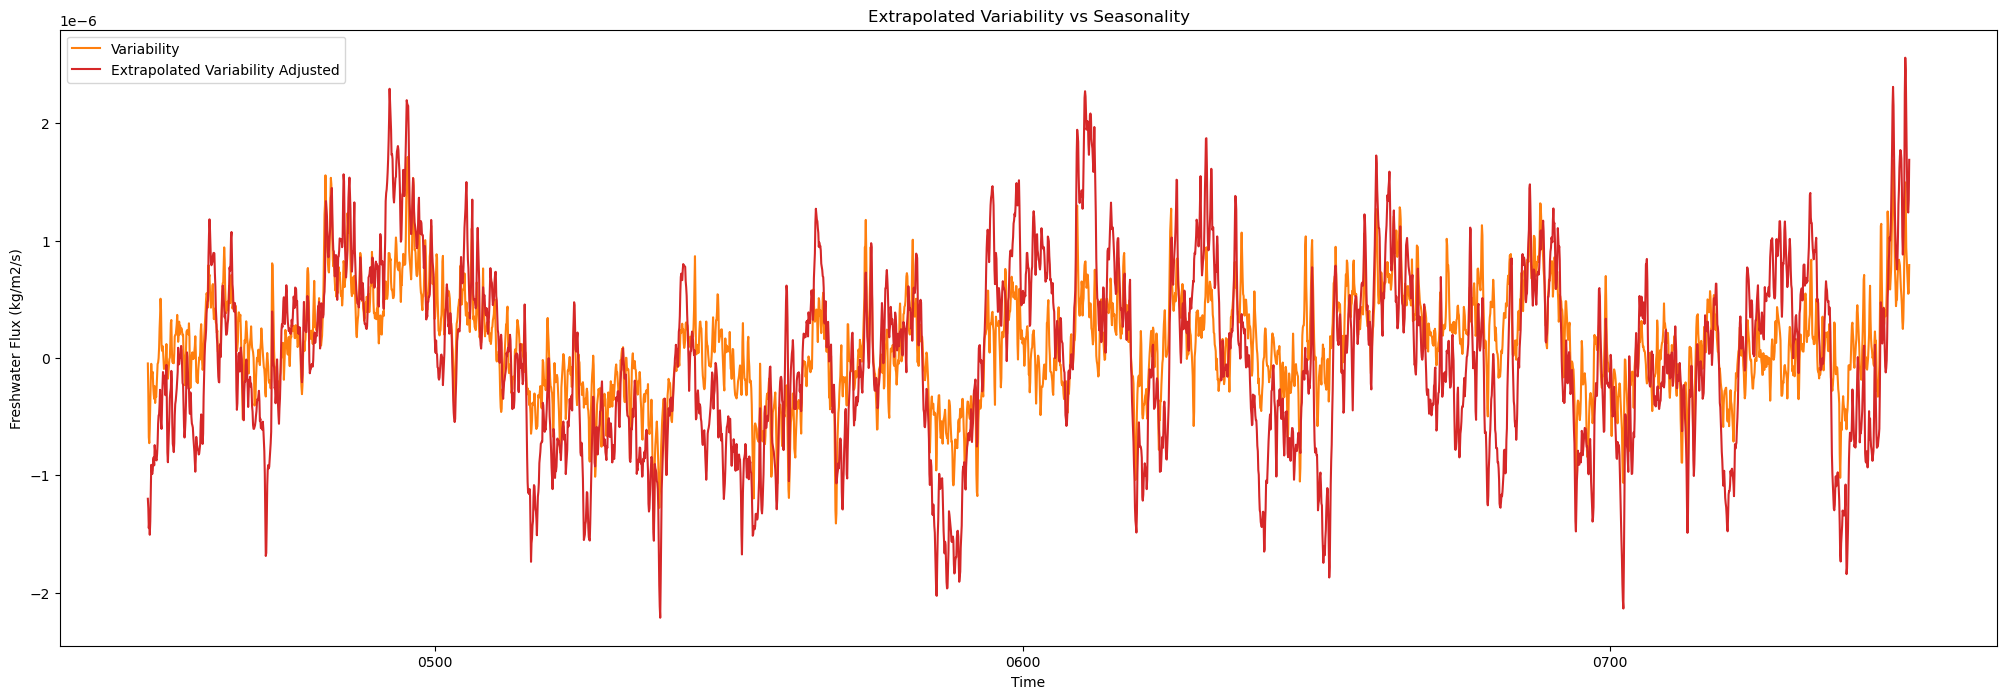

In [56]:
plt.figure(figsize=(25,8))
#model_seasonality_ts.plot(label='Seasonality', color='C0')
model_variability_ts.plot(label='Variability', color='C1')
#model_variability_extrapl_fillna_ts.plot(label='Extrapolated Variability', color='C2')
model_variability_extrapl_fillna_adj_ts.plot(label='Extrapolated Variability Adjusted', color='C3')
plt.legend()
plt.title('Extrapolated Variability vs Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')

In [7]:
# Select only first 12 months (along Time dimension) from model_seasonality
model_seasonality_12_months = model_seasonality.isel(Time=slice(0, 12))
model_seasonality_1_yr_extrapl = extrapolate_catchment_over_time(model_seasonality_12_months,
                                                                 icems, config, 
                                                                 config.SORRM_FLUX_VAR
                                                                 )

Completed timeMonthly_avg_landIceFreshwaterFlux time step 0
Completed timeMonthly_avg_landIceFreshwaterFlux time step 1
Completed timeMonthly_avg_landIceFreshwaterFlux time step 2
Completed timeMonthly_avg_landIceFreshwaterFlux time step 3
Completed timeMonthly_avg_landIceFreshwaterFlux time step 4
Completed timeMonthly_avg_landIceFreshwaterFlux time step 5
Completed timeMonthly_avg_landIceFreshwaterFlux time step 6
Completed timeMonthly_avg_landIceFreshwaterFlux time step 7
Completed timeMonthly_avg_landIceFreshwaterFlux time step 8
Completed timeMonthly_avg_landIceFreshwaterFlux time step 9
Completed timeMonthly_avg_landIceFreshwaterFlux time step 10
Completed timeMonthly_avg_landIceFreshwaterFlux time step 11


In [ ]:
model_seasonality_1_yr_extrapl_mean = model_seasonality_1_yr_extrapl[config.SORRM_FLUX_VAR].mean().compute()
model_seasonality_1_yr_extrapl_adj = model_seasonality_1_yr_extrapl - model_seasonality_1_yr_extrapl_mean

In [ ]:
# Repeat the dataarray in sorrmv21_ssn_extrapl to a length of Time = 3600. It now has a length of 12.
model_seasonality_extrapl = xr.concat([model_seasonality_1_yr_extrapl] * 300, dim='Time')
model_seasonality_extrapl['Time'] = model_variability.Time[:3600]

<xarray.Dataset>
Dimensions:                                (Time: 3600, x: 601, y: 601)
Coordinates:
  * Time                                   (Time) object 0451-01-16 12:00:00....
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    lat                                    (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    lon                                    (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    spatial_ref                            int64 ...
    month                                  (Time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (Time, y, x) float64 0.0 0.0 ... 0.0

In [10]:
model_seasonality_extrapl_ts = model_seasonality_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

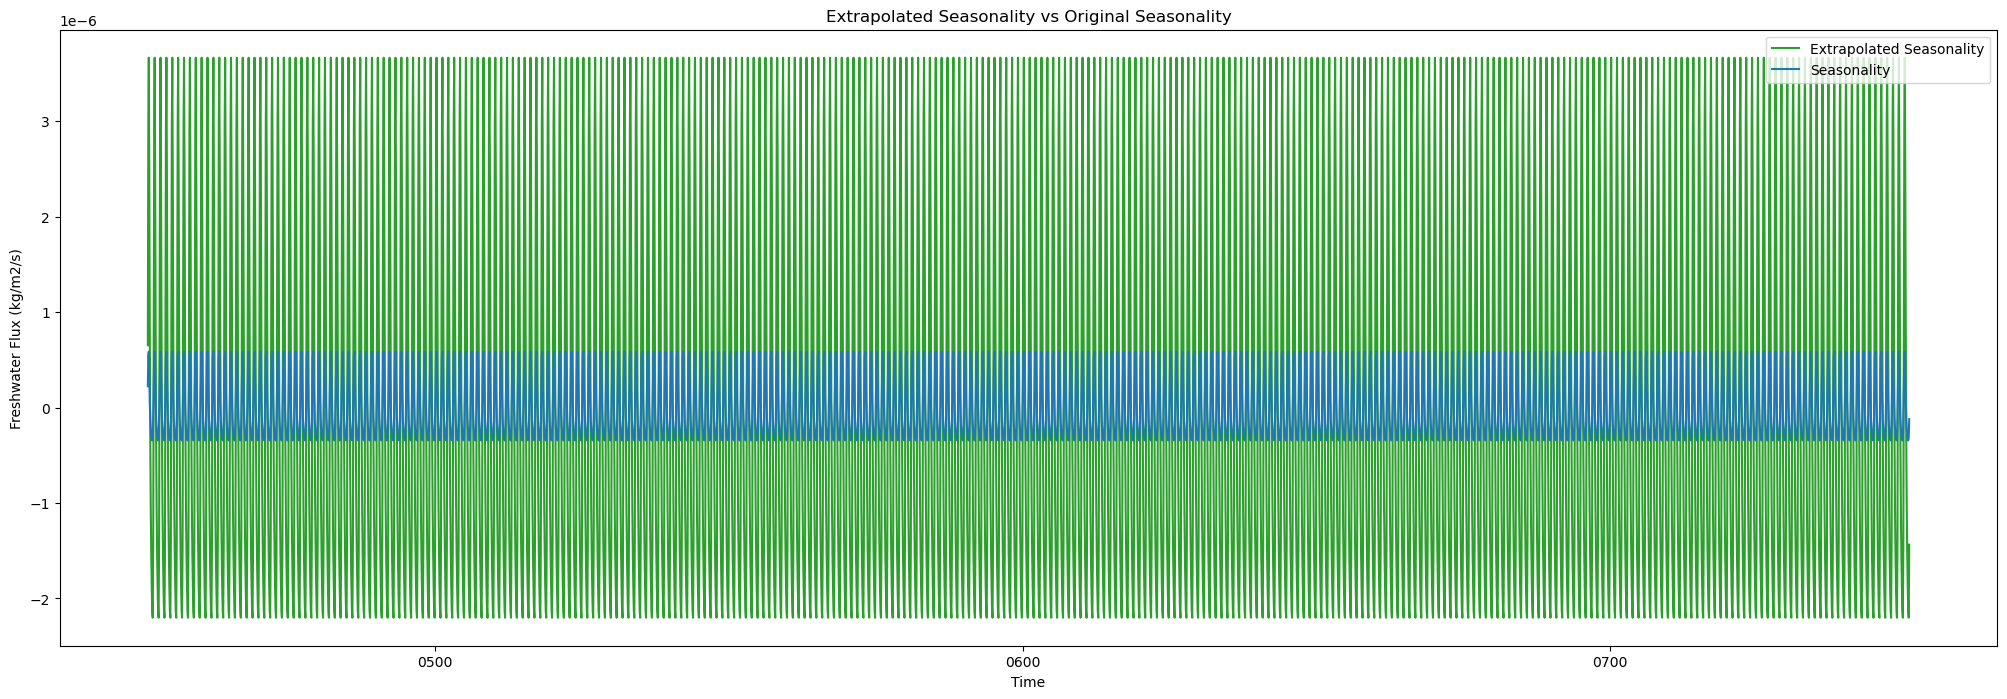

In [13]:
plt.figure(figsize=(25,8))
model_seasonality_extrapl_ts.plot(label='Extrapolated Seasonality', color='C2')
model_seasonality_ts.plot(label='Seasonality', color='C0')
plt.legend()
plt.title('Extrapolated Seasonality vs Original Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')

In [18]:
ssn_diff = model_seasonality - model_seasonality_extrapl

In [24]:
model_seasonality_extrapl_fillna = model_seasonality_extrapl.fillna(0)


In [25]:
model_seasonality_extrapl_fillna.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_seasonality_extrapolated_fillNA.nc")

In [27]:
model_variability_extrapl_fillna_adj = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA_adjusted-mean-zero.nc", chunks={config.TIME_DIM: 36})

In [28]:
model_varclim_final = model_variability_extrapl_fillna_adj + model_seasonality_extrapl_fillna

In [29]:
model_varclim_final.to_netcdf("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_varclim_final.nc")

In [30]:
model_varclim_final_ts = model_varclim_final[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

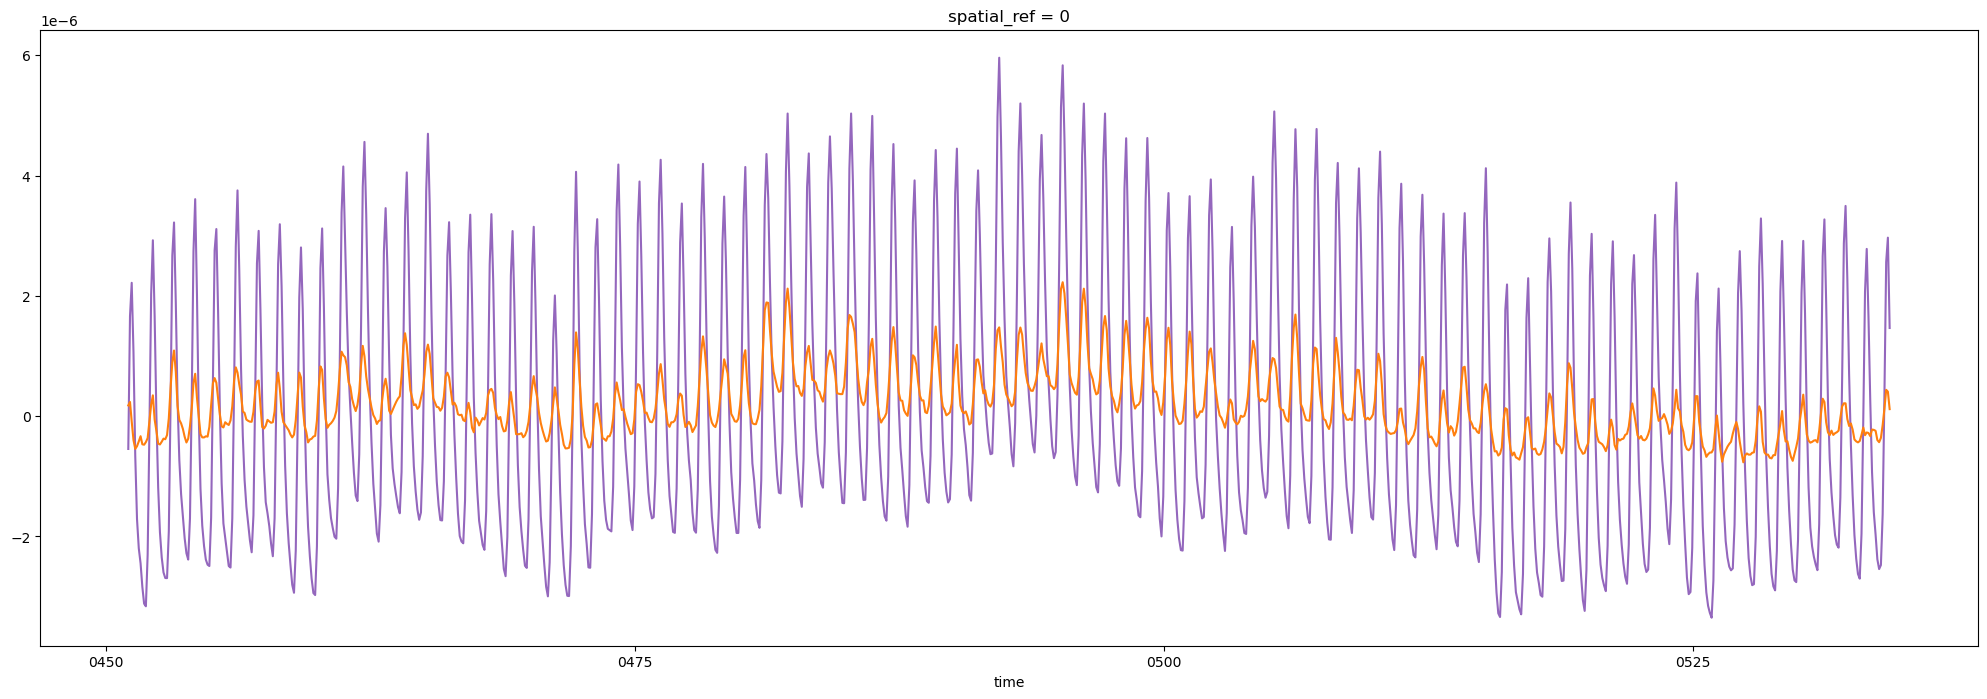

In [34]:
plt.figure(figsize=(25,8))
model_varclim_final_ts[:1000].plot(label='Final Variability + Seasonality', color='C4')
(model_variability_ts+model_seasonality_ts)[0:1000].plot(label='seasonality + Variability', color='C1')

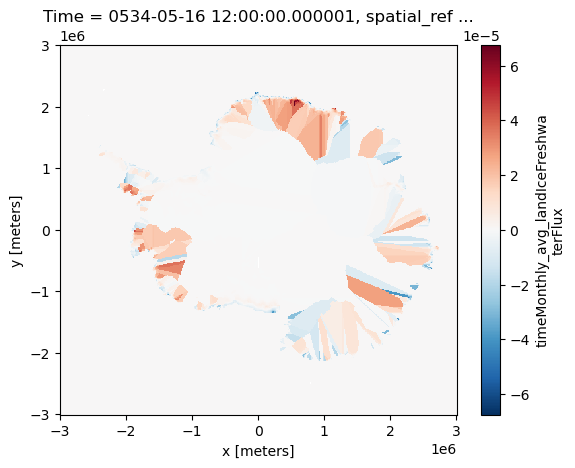

In [17]:
model_seasonality_extrapl.timeMonthly_avg_landIceFreshwaterFlux[1000].plot()

In [ ]:
model_seasonality_12_months_ts = model_seasonality_12_months[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_1_yr_extrapl_ts = model_seasonality_1_yr_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_1_yr_extrapl_adj_ts = model_seasonality_1_yr_extrapl_adj[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()
model_seasonality_extrapl_ts = model_seasonality_extrapl[config.SORRM_FLUX_VAR].mean(["x", "y"]).compute()

Text(0, 0.5, 'Freshwater Flux (kg/m2/s)')

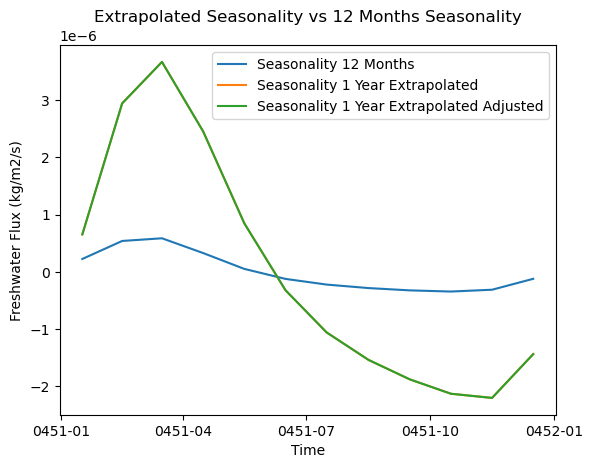

In [80]:
model_seasonality_12_months_ts.plot(label='Seasonality 12 Months', color='C0')
model_seasonality_1_yr_extrapl_ts.plot(label='Seasonality 1 Year Extrapolated', color='C1')
model_seasonality_1_yr_extrapl_adj_ts.plot(label='Seasonality 1 Year Extrapolated Adjusted', color='C2')
plt.legend()
plt.title('Extrapolated Seasonality vs 12 Months Seasonality')
plt.xlabel('Time')
plt.ylabel('Freshwater Flux (kg/m2/s)')


In [59]:
# Extrapolate seasonality to the entire ice sheet for just the first 12 time steps, which is 1 year.
model_seasonality_extrapl = model_seasonality[:12].interp_like(model_variability_extrapl[:12], method='nearest')

ValueError: Unsupported key-type <class 'slice'>

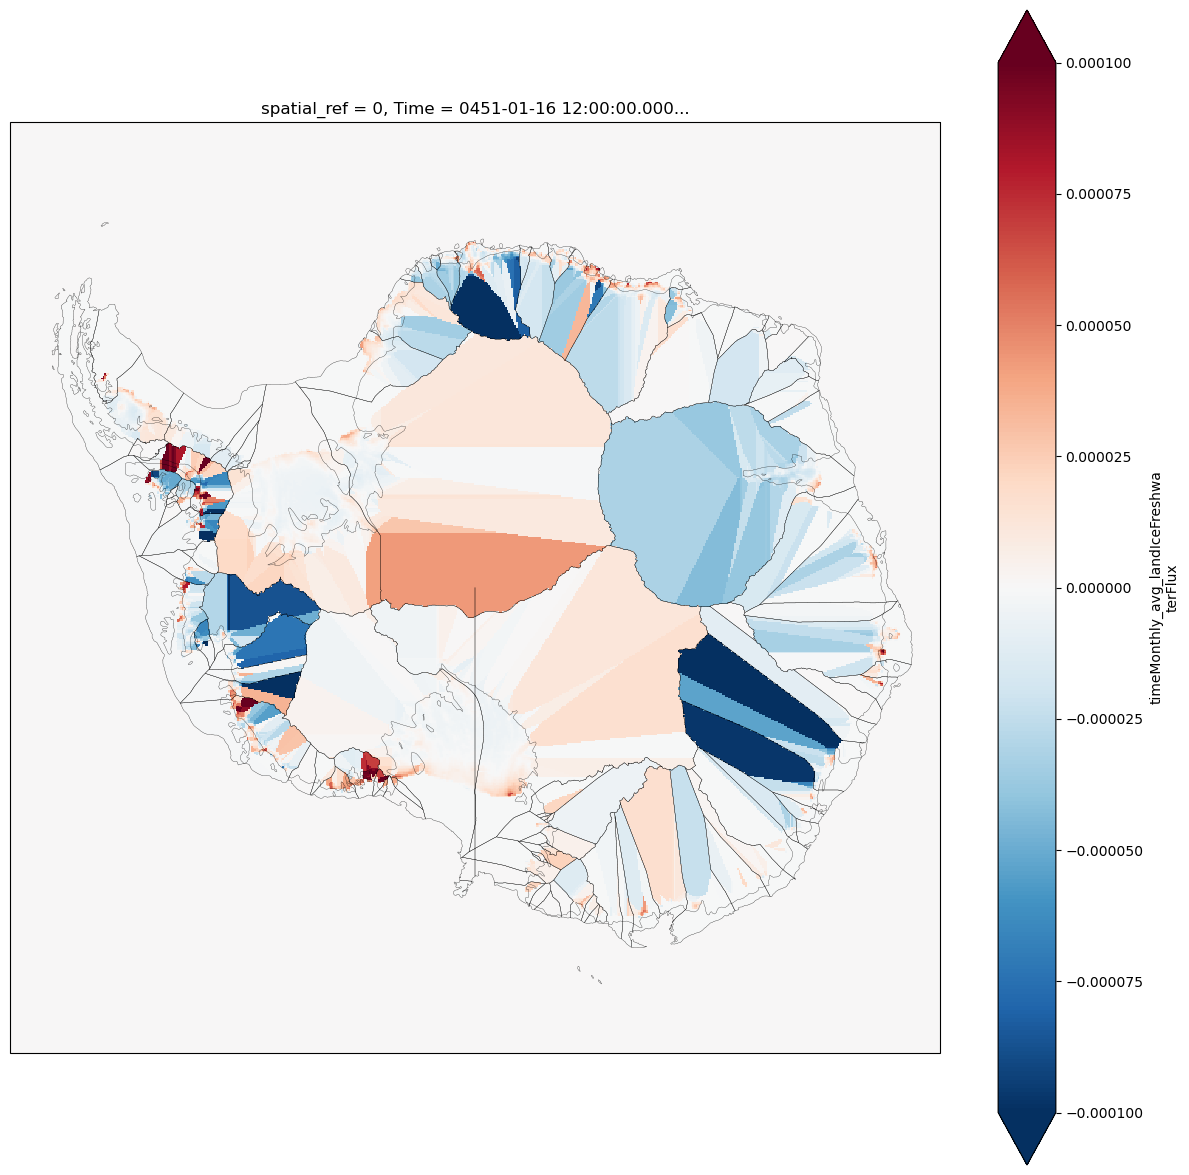

In [66]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

# icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


# ax1.patch.set_facecolor(color='lightsteelblue')
# ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
model_variability_extrapl_fillna.timeMonthly_avg_landIceFreshwaterFlux[0].plot(vmin=-0.0001, vmax=0.0001, cmap='RdBu_r')

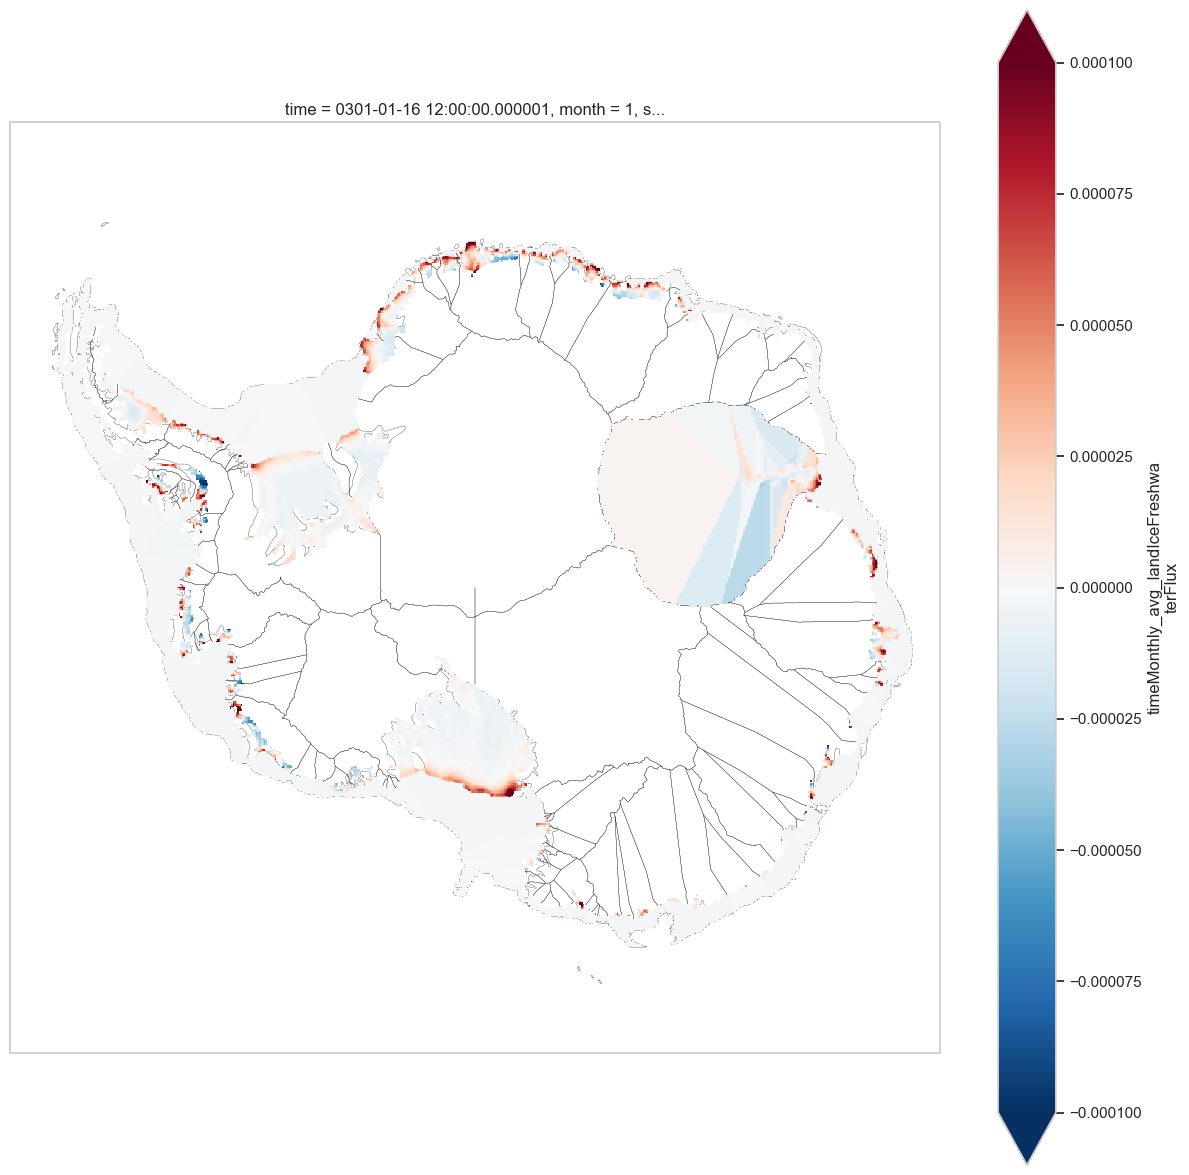

In [67]:
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

# icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


# ax1.patch.set_facecolor(color='lightsteelblue')
# ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[0].plot(ax=ax1, zorder=8, vmax=0.0001, vmin=-0.0001, cmap='RdBu_r')

In [8]:
varSORRM

<xarray.Dataset>
Dimensions:                        (y: 601, x: 601, Time: 7200)
Coordinates:
  * y                              (y) float64 -3e+06 -2.99e+06 ... 3e+06
  * x                              (x) float64 -3e+06 -2.99e+06 ... 3e+06
  * Time                           (Time) object 0301-01-16 12:00:00.000001 ....
    month                          (Time) int64 dask.array<chunksize=(7200,), meta=np.ndarray>
    spatial_ref                    int64 ...
Data variables:
    __xarray_dataarray_variable__  (Time, y, x) float64 dask.array<chunksize=(7200, 601, 601), meta=np.ndarray>

In [13]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux

varSORRM_extrapl_array = np.empty(varSORRM.__xarray_dataarray_variable__.shape)
varSORRM_extrapl_array[:] = 0 # np.nan

varSORRM_extrapl = xr.DataArray(varSORRM_extrapl_array, coords=varSORRM.__xarray_dataarray_variable__.coords, dims = varSORRM.__xarray_dataarray_variable__.dims, attrs=varSORRM.__xarray_dataarray_variable__.attrs)
varSORRM_extrapl = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(varSORRM_extrapl)))

for t in range(len(varSORRM.Time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = varSORRM.isel(Time=t)#.rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t] = result_ds.__xarray_dataarray_variable__
    del ds_data, results, merged_ds, result_ds
    print(f"Completed time step {t}")


varSORRM_extrapl = varSORRM_extrapl.fillna(0)
# Save the updated varSORRM
varSORRM_extrapl.to_netcdf(main_dir / DIR_processed / 'sorrm/SORRMv21_variability_600y_resized_NNextrapl_NaN.nc')
print("Processing complete. Updated dataset saved.")

Completed time step 0
Completed time step 1
Completed time step 2
Completed time step 3
Completed time step 4
Completed time step 5
Completed time step 6
Completed time step 7
Completed time step 8
Completed time step 9
Completed time step 10
Completed time step 11
Completed time step 12
Completed time step 13
Completed time step 14
Completed time step 15
Completed time step 16
Completed time step 17
Completed time step 18
Completed time step 19
Completed time step 20
Completed time step 21
Completed time step 22
Completed time step 23
Completed time step 24
Completed time step 25
Completed time step 26
Completed time step 27
Completed time step 28
Completed time step 29
Completed time step 30
Completed time step 31
Completed time step 32
Completed time step 33
Completed time step 34
Completed time step 35
Completed time step 36
Completed time step 37
Completed time step 38
Completed time step 39
Completed time step 40
Completed time step 41
Completed time step 42
Completed time step 4

In [15]:
sorrmv21_ssn_1yr.shape

(12, 601, 601)

In [31]:
sorrmv21_ssn_1yr_ds.rio.write_crs("epsg:3031", inplace=True);

In [34]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux

sorrmv21_ssn_extrapl_array = np.empty(sorrmv21_ssn_1yr.shape)
sorrmv21_ssn_extrapl_array[:] = np.nan

sorrmv21_ssn_1yr_ds

sorrmv21_ssn_extrapl = xr.DataArray(sorrmv21_ssn_extrapl_array, coords=sorrmv21_ssn_1yr_ds.coords, dims = sorrmv21_ssn_1yr_ds.dims, attrs=sorrmv21_ssn_1yr_ds.attrs)
sorrmv21_ssn_extrapl = xr.Dataset(data_vars=dict(timeMonthly_avg_landIceFreshwaterFlux=(sorrmv21_ssn_extrapl)))

for t in range(len(sorrmv21_ssn_1yr_ds.Time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = sorrmv21_ssn_1yr_ds.isel(Time=t)#.rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    sorrmv21_ssn_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t] = result_ds.ssn
    del ds_data, results, merged_ds, result_ds
    print(f"Completed time step {t}")


sorrmv21_ssn_extrapl = sorrmv21_ssn_extrapl.fillna(0)
# Save the updated varSORRM
#sorrmv21_ssn_extrapl.to_netcdf(main_dir / DIR_processed / 'sorrm/SORRMv21_variability_600y_resized_NNextrapl_NaN.nc')
#print("Processing complete. Updated dataset saved.")

Completed time step 0
Completed time step 1
Completed time step 2
Completed time step 3
Completed time step 4
Completed time step 5
Completed time step 6
Completed time step 7
Completed time step 8
Completed time step 9
Completed time step 10
Completed time step 11


In [ ]:
# Repeat the dataarray in sorrmv21_ssn_extrapl to a length of Time = 3600. It now has a length of 12.
sorrmv21_ssn_extrapl_repeated = xr.concat([sorrmv21_ssn_extrapl] * 300, dim='Time')
sorrmv21_ssn_extrapl_repeated['Time'] = varSORRM.Time[:3600]

<Figure size 640x480 with 0 Axes>

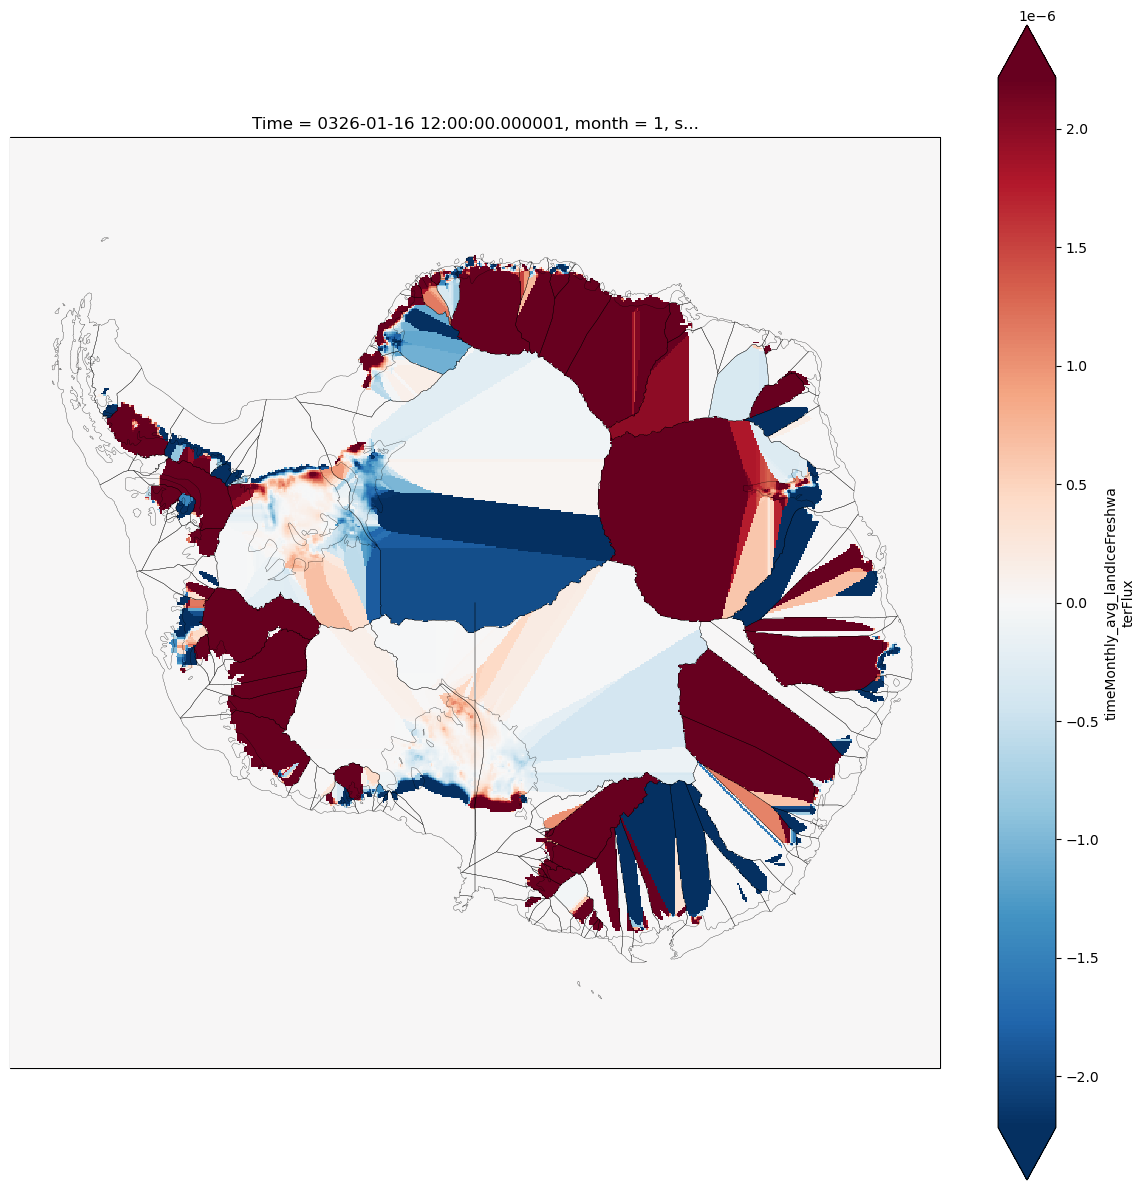

In [46]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[300].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmin/10, vmax=absmin/10)
ax1.coastlines(lw=0.2, zorder=8)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
#plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

In [47]:
varSORRM_extrapl_ts = varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y'])

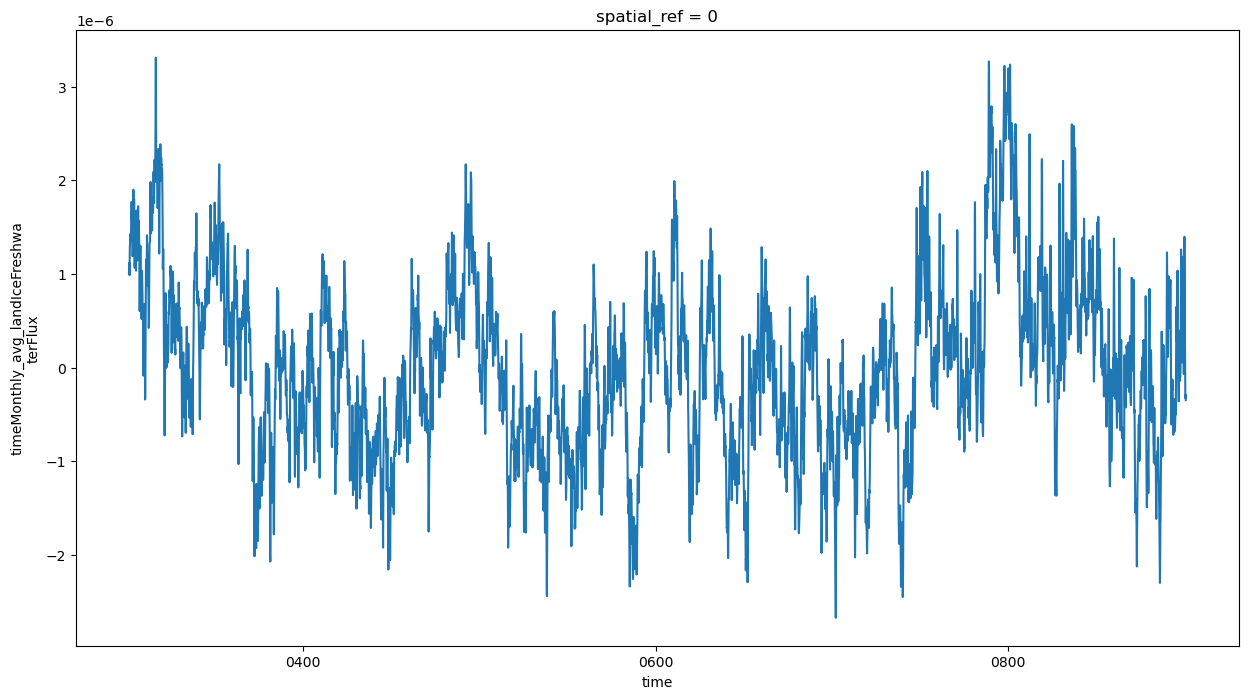

In [49]:
plt.figure(figsize=(15,8))
varSORRM_extrapl_ts.plot()

<Figure size 640x480 with 0 Axes>

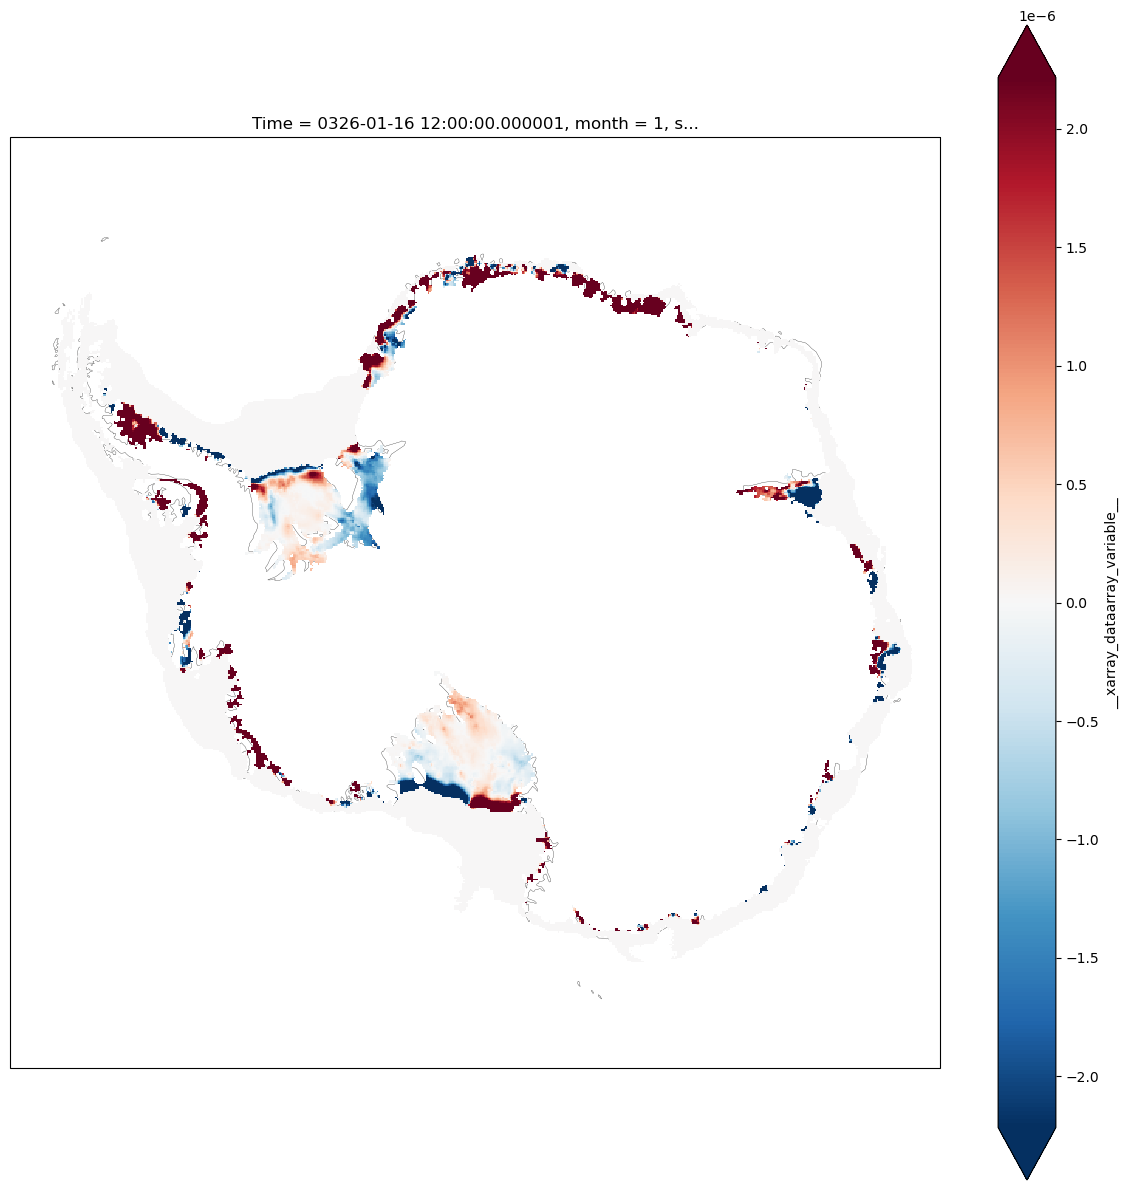

In [39]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
#icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM.__xarray_dataarray_variable__[300].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmin/10, vmax=absmin/10)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
#plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

In [32]:
varSORRM_extrapl_noNaN = varSORRM_extrapl.fillna(0)

In [35]:
varSORRM_extrapl_noNaN.to_netcdf(main_dir / DIR_processed / 'SORRMv21_variability_300y_NNextrapl_noNaN.nc')

In [1]:
# sns.set_theme(style="whitegrid")

plt.clf()
plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=3)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


ax1.patch.set_facecolor(color='lightsteelblue')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)
varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[1000].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6, vmin=-absmax, vmax=absmax)
# varSORRM.timeMonthly_avg_landIceFreshwaterFlux[10].plot(ax=ax1, cmap="RdBu_r", add_colorbar=True, zorder=6)
plt.savefig('ICV_extrapl_t-{}.png'.format(10), dpi=300)

NameError: name 'plt' is not defined

In [ ]:

sns.set_theme(style="whitegrid")

for t in range(len(varSORRM.time)):
    plt.clf()
    plt.figure(figsize=(15,15))
    ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

    # icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
    # icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


    #ax1.patch.set_facecolor(color='lightsteelblue')
    #ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
    ax1.coastlines(lw=0.2)
    varSORRM_extrapl.timeMonthly_avg_landIceFreshwaterFlux[t].plot(ax=ax1, cmap="RdBu_r", vmin=icv_vmin, vmax=icv_vmax, add_colorbar=True)
    # savefig with 4 digits for the time step
    plt.savefig('ICV_extrapl_t-{:04d}.png'.format(t), dpi=300)
    plt.close()

In [201]:
# Create a dummy xarray dataArray in the shape of varSORRM.timeMonthly_avg_landIceFreshwaterFlux


for t in range(len(varSORRM.time)):  # Change to range(len(varSORRM.time)) for full processing
    ds_data = varSORRM.isel(time=t).rename({'x1': 'x', 'y1': 'y'})
    
    # Process all ice shelves in parallel
    ice_shelf_range = range(33, 133)
    results = [process_ice_shelf(ds_data, iceShelfNum, icems) for iceShelfNum in ice_shelf_range]

    merged_ds = merge_datasets(results)
    result_ds = copy_subset_data(ds_data, merged_ds)

    # Replace the values of varSORRM with the values from result_ds
    for var in result_ds.data_vars:
        if var in varSORRM:
            # Create a boolean mask for non-NaN values in result_ds
            update_mask = ~np.isnan(result_ds[var].values)
            
            # Update varSORRM where update_mask is True
            varSORRM[var].values[t, update_mask] = result_ds[var].values[update_mask]
    print(f"Completed time step {t}")

# Save the updated varSORRM
varSORRM.to_netcdf('path_to_updated_varSORRM.nc')
print("Processing complete. Updated dataset saved.")

Completed time step 0


In [ ]:
for t in range(1):# len(varSORRM.time)):
    ds_data = varSORRM.isel(time=t)
    ds_data = ds_data.rename({'x1':'x','y1':'y'})
    # Create a xarray dataArray in the shape of ds_data
    
    # ds = ds.timeMonthly_avg_landIceFreshwaterFlux
    for iceShelfNum in range(34,133):
        ds = clip_data(ds_data, iceShelfNum)
        ice_shelf_mask = icems.loc[[iceShelfNum],'geometry'].apply(mapping)
        # Process each variable in the dataset
        for var_name, da in ds.data_vars.items():
            # Check if the variable has the correct dimensions (x, y, Time)
            if set(da.dims) == {'x', 'y'}:
                # Fill NaN values
                ds[var_name] = fill_nan_with_nearest_neighbor(da)
        # Fill values from ds to the same x,y coordinates in ds_data
        
        ds = ds.rio.clip(ice_shelf_mask,icems.crs)
        ds.to_netcdf(main_dir / DIR_interim / 'ICV_300y_extrapolate/SORRMv21_ICV_t{}_iceShelf{}.nc'.format(t, iceShelfNum))
        del ds, ice_shelf_mask
        print("filled data for time: {}, ice shelf: {}".format(t, iceShelfNum))
    del ds_data

# BENCHMARK DIFFERENT EXTRAPOLATION ALGORITHMS

In [16]:
from aislens.config import config
model_variability = xr.open_dataset(config.FILE_VARIABILITY, chunks={config.TIME_DIM: 36})
da_example = model_variability[config.SORRM_FLUX_VAR]

In [22]:
# Benchmark: compare BallTree, cKDTree and ndimage fills using aislens implementations
import time
import numpy as np
import xarray as xr
from scipy import ndimage
from scipy.spatial import cKDTree

# Import implementations from the package (wrappers exist in aislens.utils)
from aislens import utils as au

def to_numpy_2d(da):
    # Accept xarray.DataArray or numpy 2D array; compute if dask-backed
    if isinstance(da, xr.DataArray):
        if hasattr(da.data, 'compute'):
            return da.compute().values
        return da.values
    return np.asarray(da)

def run_benchmark(arr2d, n_runs=3):
    arr = arr2d.astype(float)
    timings = {'ball': [], 'ckd': [], 'nd': []}
    results = {}

    # Warm-up
    _ = au.fill_nan_with_nearest_neighbor_vectorized_balltree(xr.DataArray(arr, dims=("y","x")))
    _ = au.fill_nan_with_nearest_neighbor_vectorized(xr.DataArray(arr, dims=("y","x")))
    _ = au.fill_nan_with_nearest_neighbor_ndimage(xr.DataArray(arr, dims=("y","x")))

    for _ in range(n_runs):
        t0 = time.perf_counter(); r = au.fill_nan_with_nearest_neighbor_vectorized_balltree(xr.DataArray(arr.copy(), dims=("y","x"))); t1 = time.perf_counter()
        timings['ball'].append(t1-t0); results['ball'] = (r.values if isinstance(r, xr.DataArray) else np.asarray(r))

        t0 = time.perf_counter(); r = au.fill_nan_with_nearest_neighbor_vectorized(xr.DataArray(arr.copy(), dims=("y","x"))); t1 = time.perf_counter()
        timings['ckd'].append(t1-t0); results['ckd'] = (r.values if isinstance(r, xr.DataArray) else np.asarray(r))

        t0 = time.perf_counter(); r = au.fill_nan_with_nearest_neighbor_ndimage(xr.DataArray(arr.copy(), dims=("y","x"))); t1 = time.perf_counter()
        timings['nd'].append(t1-t0); results['nd'] = (r.values if isinstance(r, xr.DataArray) else np.asarray(r))

    med = {k: float(np.median(v)) for k,v in timings.items()}
    print('Median timings (s):', med)
    ref = results['ckd']
    print('max abs diff ball vs ckd:', np.nanmax(np.abs(results['ball'] - ref)))
    print('max abs diff nd vs ckd:', np.nanmax(np.abs(results['nd'] - ref)))
    return med, results

# Select a representative 2D slice from notebook variables; prefer varSORRM or model_variability
#da_example = globals().get('varSORRM') or globals().get('model_variability')
if da_example is None:
    # fallback: search for first xarray.DataArray with x,y dims in a snapshot of globals()
    import inspect
    for name, val in list(globals().items()):
        if isinstance(val, xr.DataArray) and 'x' in val.dims and 'y' in val.dims:
            da_example = val
            break

if da_example is None:
    raise RuntimeError('No candidate 2D DataArray found in notebook globals. Define `varSORRM` or `model_variability` or set `da_example` manually.')

# Pick first time slice if time dimension exists
if 'Time' in da_example.dims:
    da_test = da_example.isel(Time=0).compute()
else:
    da_test = da_example.compute()

arr2d = to_numpy_2d(da_test)
print('Running benchmark on array shape:', arr2d.shape)
USE_INDEX_MAP = False  # set True to benchmark the cached index-map / ndimage mapping approach

if USE_INDEX_MAP:
    # Demonstrate compute/load of index map and apply it (uses new helpers in aislens.utils)
    mask = np.isnan(arr2d)
    idx_map = au.compute_nearest_index_map(mask)
    # time applying the index map a few times
    import time as _time
    _t0 = _time.perf_counter()
    _filled = au.fill_with_index_map(xr.DataArray(arr2d, dims=("y","x")), idx_map)
    _t1 = _time.perf_counter()
    print('index_map apply time (s):', _t1 - _t0)
    # Also run the other benchmarked functions for comparison
    med, results = run_benchmark(arr2d, n_runs=3)
else:
    med, results = run_benchmark(arr2d, n_runs=3)

# Convert benchmark numpy results back to xarray.DataArray matching the spatial template (da_test)
def _np_to_da(arr, template):
    # arr: numpy array 2D; template: xarray.DataArray with same spatial dims (y,x)
    import numpy as _np
    if isinstance(template, xr.DataArray):
        coords = {dim: template.coords[dim] for dim in template.dims}
        return xr.DataArray(_np.asarray(arr), dims=template.dims, coords=coords, attrs=template.attrs)
    else:
        return xr.DataArray(_np.asarray(arr))

# results contains numpy arrays or xarray objects; make `results_xr` dict with DataArrays
results_xr = {}
for k, v in results.items():
    try:
        arr_np = v.values if isinstance(v, xr.DataArray) else (v if hasattr(v, 'ndim') else np.asarray(v))
    except Exception:
        arr_np = np.asarray(v)
    # ensure arr_np is 2D; if shape differs, try to reshape using da_test shape
    if arr_np.shape != tuple(da_test.shape):
        # attempt to squeeze or reshape conservatively
        try:
            arr_np = np.asarray(arr_np).reshape(tuple(da_test.shape))
        except Exception:
            pass
    results_xr[k] = _np_to_da(arr_np, da_test)

# expose convenience names in notebook namespace
filled_ckd = results_xr.get('ckd')
filled_ball = results_xr.get('ball')
filled_nd = results_xr.get('nd')

print('Converted benchmark outputs to xarray DataArrays: filled_ckd, filled_ball, filled_nd')
# end of benchmark cell

Running benchmark on array shape: (601, 601)
Median timings (s): {'ball': 0.7327834999996412, 'ckd': 0.8099396670004353, 'nd': 0.015544124998996267}
max abs diff ball vs ckd: 0.00014677981419975684
max abs diff nd vs ckd: 0.0001509032550475278
Converted benchmark outputs to xarray DataArrays: filled_ckd, filled_ball, filled_nd


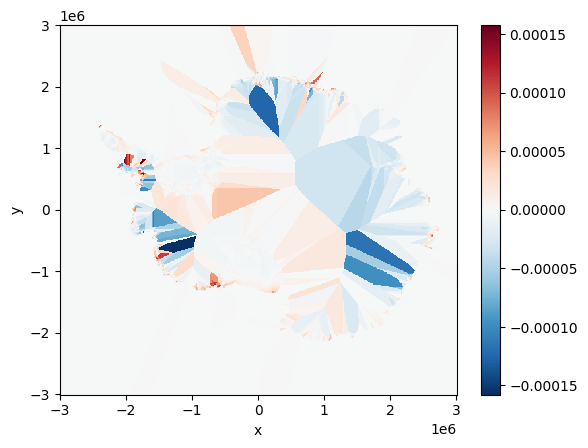

In [24]:
filled_nd.plot()

In [19]:
import geopandas as gpd

icems = gpd.read_file(config.FILE_ICESHELFMASKS);
icems = icems.to_crs({'init': config.CRS_TARGET});

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Mask alignment method used: rasterize
ice_mask2 dims/shape: ('y', 'x') (601, 601)
filled_nd dims/shape: ('y', 'x') (601, 601)


Text(0.5, 1.0, 'ndimage filled (masked) — method: rasterize')

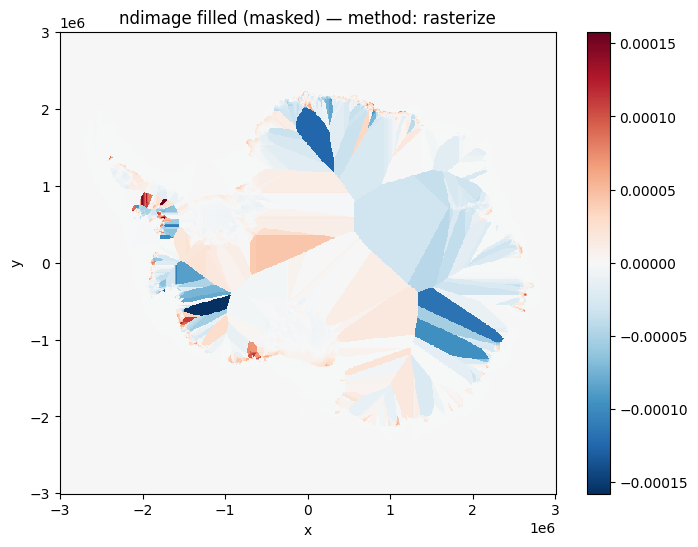

In [20]:
# Robust mask alignment: try reproject_match -> reindex -> rasterize fallback
import numpy as _np
import xarray as _xr
from shapely.geometry import mapping
method_used = None

# Attempt 1: force the rioxarray clip result to match the template grid
try:
    clipped_matched = clipped.rio.reproject_match(da_test)
    ice_mask2 = ~_np.isnan(clipped_matched)
    method_used = 'reproject_match'
except Exception as _e_reproj:
    # Attempt 2: reindex the mask to the template coords using nearest neighbor
    try:
        ice_mask2 = ice_mask.reindex({
            da_test.dims[0]: da_test.coords[da_test.dims[0]],
            da_test.dims[1]: da_test.coords[da_test.dims[1]]
        }, method='nearest', fill_value=False)
        method_used = 'reindex_nearest'
    except Exception as _e_reindex:
        # Attempt 3: rasterize the icems geometries directly onto the da_test grid
        try:
            from rasterio.features import rasterize
            transform = da_test.rio.transform()
            out_shape = tuple(da_test.shape)
            geoms = [(mapping(g), 1) for g in icems.geometry]
            mask_arr = rasterize(geoms, out_shape=out_shape, transform=transform, fill=0, dtype='uint8')
            ice_mask2 = _xr.DataArray(mask_arr.astype(bool), dims=da_test.dims,
                                     coords={dim: da_test.coords[dim] for dim in da_test.dims})
            method_used = 'rasterize'
        except Exception as _e_rast:
            # Build a clear multi-line error message and raise it
            msg = (
                'Failed to produce aligned ice mask with reproject_match, reindex, and rasterize.\n'
                f'reproject_match error: {_e_reproj}\n'
                f'reindex error: {_e_reindex}\n'
                f'rasterize error: {_e_rast}'
            )
            raise RuntimeError(msg)

# Ensure dims ordering matches the filled arrays
if ice_mask2.dims != filled_nd.dims:
    if set(ice_mask2.dims) == set(filled_nd.dims):
        ice_mask2 = ice_mask2.transpose(*filled_nd.dims)

print('Mask alignment method used:', method_used)
print('ice_mask2 dims/shape:', ice_mask2.dims, ice_mask2.shape)
print('filled_nd dims/shape:', filled_nd.dims, filled_nd.shape)

# Apply mask: outside ice -> 0 (change to other=_np.nan if you prefer NaNs)
filled_nd = filled_nd.where(ice_mask2, other=0)
filled_ckd = filled_ckd.where(ice_mask2, other=0)
filled_ball = filled_ball.where(ice_mask2, other=0)

# Quick visual check
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
filled_nd.plot()
plt.title(f'ndimage filled (masked) — method: {method_used}')

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


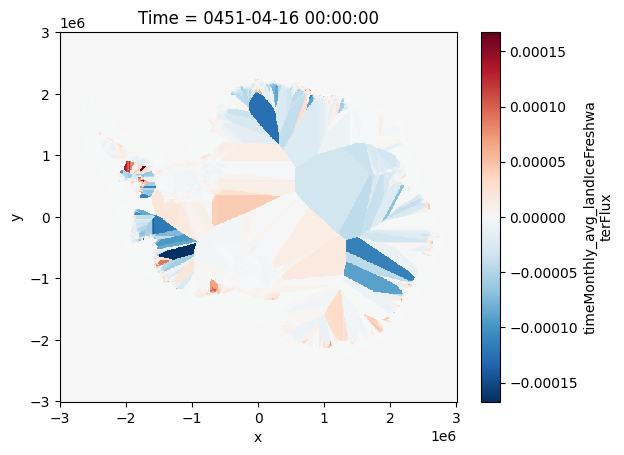

In [41]:
var_extrapl_test = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_var_extrapl_test_small.nc")
var_extrapl_test.timeMonthly_avg_landIceFreshwaterFlux[3].plot()


/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


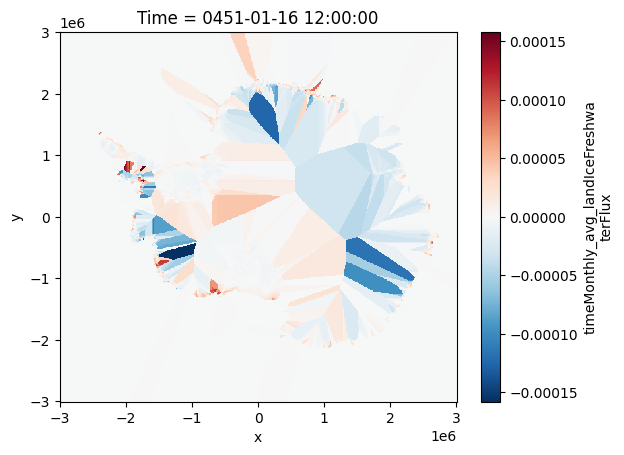

In [ ]:
var_extrapl_test = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_var_extrapl_full.nc")
var_extrapl_test.timeMonthly_avg_landIceFreshwaterFlux[0].plot()

Text(0.5, 1.0, 'ndimage filled (masked) — method: rasterize')

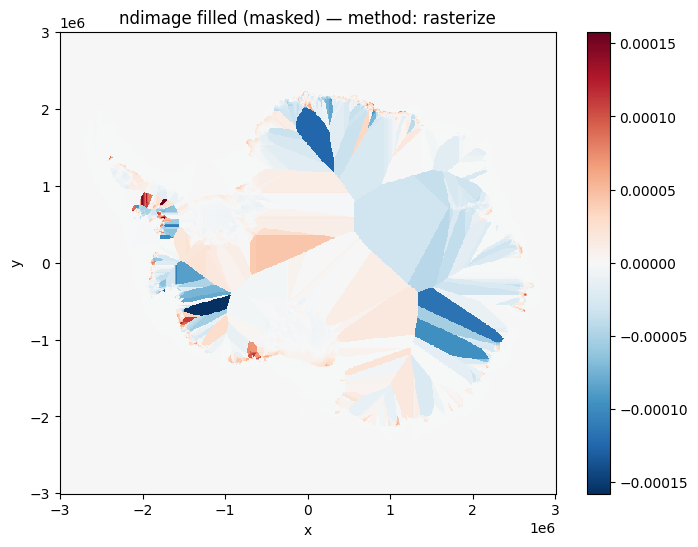

In [21]:
# Quick visual check
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
filled_nd.plot()
plt.title(f'ndimage filled (masked) — method: {method_used}')

In [7]:
# Diagnostics: inspect CRS/transform, mask alignment, and offending pixels
# Set APPLY_RASTERIZE=True to force a rasterized mask to be created and applied
APPLY_RASTERIZE = True
THRESH = 0  # threshold for considering a value 'non-zero' (absolute)
import numpy as _np
import xarray as _xr
from shapely.geometry import mapping

def _print_meta():
    print('--- Template (da_test) info ---')
    try:
        print('da_test.dims/shape:', da_test.dims, tuple(da_test.shape))
    except Exception as e:
        print('da_test not found or invalid:', e)
    try:
        print('da_test.rio.crs:', da_test.rio.crs)
        print('da_test.rio.transform:', da_test.rio.transform())
    except Exception as e:
        print('da_test has no rioxarray metadata or rioxarray not available:', e)

    print('--- Ice-shelf geometries (icems) info ---')
    try:
        print('icems.crs:', icems.crs)
        print('icems count:', len(icems))
    except Exception as e:
        print('icems not found or invalid:', e)

    for name in ['ice_mask', 'ice_mask2']:
        if name in globals():
            m = globals()[name]
            try:
                print(f'{name} dims/shape:', m.dims, tuple(m.shape))
            except Exception as e:
                print(f'{name} present but could not read dims/shape:', e)

_print_meta()

def _check_filled(name, da, mask=None):
    print(f'--- Checking {name} ---')
    if da is None:
        print('Not found in globals()')
        return
    try:
        vals = da.values if isinstance(da, _xr.DataArray) else _np.asarray(da)
    except Exception as e:
        print('Could not obtain numpy values for', name, e)
        return
    nz = _np.count_nonzero(_np.abs(vals) > THRESH)
    print(name, 'non-zero (abs>%s):' % THRESH, int(nz))

    # attempt to align mask to this da if mask is provided and shapes differ
    if 'ice_mask2' in globals():
        m = globals()['ice_mask2']
        try:
            if tuple(m.shape) != tuple(da.shape):
                # try reindex by coordinates (nearest)
                try:
                    m_al = m.reindex({da.dims[0]: da.coords[da.dims[0]], da.dims[1]: da.coords[da.dims[1]]}, method='nearest', fill_value=False)
                except Exception:
                    m_al = None
            else:
                m_al = m
        except Exception as e:
            print('Error while aligning ice_mask2 to', name, e)
            m_al = None

        if m_al is not None:
            try:
                outside = _np.logical_and(~_np.asarray(m_al), _np.abs(vals) > THRESH)
                n_out = int(_np.count_nonzero(outside))
                print(name, 'non-zero outside ice_mask2:', n_out)
                if n_out > 0:
                    # sample offending indices and coordinates (y,x)
                    inds = _np.argwhere(outside)
                    print('sample offending indices (y,x):', inds[:10].tolist())
                    # map to coords if possible
                    coords_sample = []
                    for (iy, ix) in inds[:10]:
                        try:
                            x = da.coords[da.dims[1]].values[int(ix)]
                            y = da.coords[da.dims[0]].values[int(iy)]
                        except Exception:
                            x, y = int(ix), int(iy)
                        coords_sample.append((float(x), float(y)))
                    print('sample coordinates (x,y):', coords_sample)
            except Exception as e:
                print('Could not compute outside-mask diagnostics for', name, e)
    else:
        print('ice_mask2 not present; cannot check outside-mask counts')

# Run checks for each filled result available in the notebook
for nm in ['filled_nd', 'filled_ckd', 'filled_ball']:
    _check_filled(nm, globals().get(nm))

# Optional: force a strict rasterize-based mask and apply it to filled_* (useful if all else fails)
if APPLY_RASTERIZE:
    try:
        from rasterio.features import rasterize
        transform = da_test.rio.transform()
        out_shape = tuple(da_test.shape)
        geoms = [(mapping(g), 1) for g in icems.geometry]
        mask_arr = rasterize(geoms, out_shape=out_shape, transform=transform, fill=0, dtype='uint8')
        ice_mask_r = _xr.DataArray(mask_arr.astype(bool), dims=da_test.dims, coords={dim: da_test.coords[dim] for dim in da_test.dims})
        print('Rasterized mask created, shape:', ice_mask_r.shape)
        # apply
        if 'filled_nd' in globals(): globals()['filled_nd'] = globals()['filled_nd'].where(ice_mask_r, other=0)
        if 'filled_ckd' in globals(): globals()['filled_ckd'] = globals()['filled_ckd'].where(ice_mask_r, other=0)
        if 'filled_ball' in globals(): globals()['filled_ball'] = globals()['filled_ball'].where(ice_mask_r, other=0)
        print('Applied rasterized mask to filled_*')
    except Exception as e:
        print('Rasterize fallback failed:', e)

print('Diagnostics complete — set APPLY_RASTERIZE=True to force and apply a rasterized mask if desired')


--- Template (da_test) info ---
da_test not found or invalid: name 'da_test' is not defined
da_test has no rioxarray metadata or rioxarray not available: name 'da_test' is not defined
--- Ice-shelf geometries (icems) info ---
icems not found or invalid: name 'icems' is not defined
--- Checking filled_nd ---
Not found in globals()
--- Checking filled_ckd ---
Not found in globals()
--- Checking filled_ball ---
Not found in globals()
Rasterize fallback failed: name 'da_test' is not defined
Diagnostics complete — set APPLY_RASTERIZE=True to force and apply a rasterized mask if desired


In [8]:
# Diagnostic cell — paste into the notebook and run
import numpy as np
import xarray as xr
from scipy import ndimage

# synthetic small test (same as the unit test)
nt, ny, nx = 2, 4, 5
data = np.full((nt, ny, nx), np.nan, dtype=float)
data[0, 1, 1] = 10.0
data[0, 2, 3] = 20.0
data[1, 0, 0] = 5.0
data[1, 3, 4] = 15.0

da = xr.DataArray(data[0], dims=("y","x"))
print("input shape:", da.shape, "dims:", da.dims, "dtype:", da.dtype)

arr = da.values
valid = ~np.isnan(arr)
print("valid mask shape:", valid.shape, "sum valid:", valid.sum())

inds = ndimage.distance_transform_edt(~valid, return_indices=True)
print("distance_transform_edt returned type:", type(inds))
if isinstance(inds, tuple):
    print("tuple lengths / shapes:", [i.shape for i in inds], [i.dtype for i in inds])
else:
    print("ndarray shape:", inds.shape, "dtype:", inds.dtype)

# Normalize indices to iy, ix arrays
if isinstance(inds, tuple):
    iy, ix = (i.astype(int) for i in inds)
else:
    inds = inds.astype(int)
    iy, ix = inds[0], inds[1]
print("iy.shape, ix.shape:", iy.shape, ix.shape)
print("iy dtype:", iy.dtype, "ix dtype:", ix.dtype)

# Gather nearest values and inspect shapes
nearest_vals = arr[iy, ix]
print("nearest_vals shape:", nearest_vals.shape)
filled = np.where(valid, arr, nearest_vals)
print("filled shape:", filled.shape)

# sanity-check indexing: flatten -> ravel based approach
flat = arr.ravel()
flat_nearest_via_ravel = flat[iy.ravel() * nx + ix.ravel()].reshape((ny, nx))
print("flat_nearest_via_ravel shape:", flat_nearest_via_ravel.shape)
print("equal (nearest_vals vs flat_nearest_via_ravel)?", np.allclose(nearest_vals, flat_nearest_via_ravel, equal_nan=True))

# Print small sample of arrays
print("arr:\n", arr)
print("iy (sample 5):\n", iy.flatten()[:5])
print("ix (sample 5):\n", ix.flatten()[:5])
print("nearest_vals (sample):\n", nearest_vals)
print("filled:\n", filled)

input shape: (4, 5) dims: ('y', 'x') dtype: float64
valid mask shape: (4, 5) sum valid: 2
distance_transform_edt returned type: <class 'tuple'>
tuple lengths / shapes: [(4, 5), (2, 4, 5)] [dtype('float64'), dtype('int32')]
iy.shape, ix.shape: (4, 5) (2, 4, 5)
iy dtype: int64 ix dtype: int64
nearest_vals shape: (2, 4, 5)
filled shape: (2, 4, 5)


ValueError: operands could not be broadcast together with shapes (20,) (40,) 

2.8833333333333333

In [50]:
import numpy as np
import xarray as xr
from scipy import ndimage
from scipy.spatial import cKDTree

def robust_ndimage_fill(arr2d):
    """Fill NaNs in a 2D numpy array using scipy.ndimage distance transform
    with robust handling of different scipy return formats.

    Returns a filled 2D numpy array with the same shape as arr2d.
    """
    arr = np.asarray(arr2d)
    if arr.ndim != 2:
        raise ValueError('robust_ndimage_fill expects a 2D array')
    ny, nx = arr.shape
    valid = ~np.isnan(arr)
    if np.all(valid) or np.all(~valid):
        return arr.copy()

    res = ndimage.distance_transform_edt(~valid, return_indices=True)

    iy = ix = None
    if isinstance(res, tuple):
        if len(res) == 2:
            a0, a1 = res[0], res[1]
            if getattr(a0, 'ndim', None) == 2 and getattr(a1, 'ndim', None) == 2:
                iy = a0.astype(int)
                ix = a1.astype(int)
            elif getattr(a0, 'ndim', None) == 2 and getattr(a1, 'ndim', None) == 3:
                inds = np.asarray(a1).astype(int)
                iy, ix = inds[0], inds[1]
            else:
                inds = np.asarray(res[-1]).astype(int)
                if inds.ndim == 3:
                    iy, ix = inds[0], inds[1]
                elif inds.ndim == 2 and inds.shape[0] == 2:
                    iy, ix = inds[0], inds[1]
    else:
        arr_res = np.asarray(res).astype(int)
        if arr_res.ndim == 3:
            iy, ix = arr_res[0], arr_res[1]

    if iy is None or ix is None:
        yy, xx = np.nonzero(valid)
        vals = arr[yy, xx]
        pts = np.column_stack((yy, xx))
        tree = cKDTree(pts)
        all_pts = np.column_stack(np.nonzero(np.ones_like(arr)))
        _, idx = tree.query(all_pts, k=1)
        nearest = vals[idx].reshape((ny, nx))
        return np.where(valid, arr, nearest)

    iy = np.asarray(iy).astype(int)
    ix = np.asarray(ix).astype(int)
    if iy.shape != (ny, nx) or ix.shape != (ny, nx):
        yy, xx = np.nonzero(valid)
        vals = arr[yy, xx]
        pts = np.column_stack((yy, xx))
        tree = cKDTree(pts)
        all_pts = np.column_stack(np.nonzero(np.ones_like(arr)))
        _, idx = tree.query(all_pts, k=1)
        nearest = vals[idx].reshape((ny, nx))
        return np.where(valid, arr, nearest)

    nearest_vals = arr[iy, ix]
    filled = np.where(valid, arr, nearest_vals)
    return filled

nt, ny, nx = 2, 4, 5
data = np.full((nt, ny, nx), np.nan, dtype=float)
data[0, 1, 1] = 10.0
data[0, 2, 3] = 20.0
data[1, 0, 0] = 5.0
data[1, 3, 4] = 15.0

print('\nRunning robust_ndimage_fill demo on synthetic slices...')
for t in range(nt):
    arr = data[t]
    print('\nSlice', t, 'input shape:', arr.shape)
    filled = robust_ndimage_fill(arr)
    print('filled shape:', filled.shape)
    print('filled array:\n', filled)



Running robust_ndimage_fill demo on synthetic slices...

Slice 0 input shape: (4, 5)
filled shape: (4, 5)
filled array:
 [[10. 10. 10. 20. 20.]
 [10. 10. 10. 20. 20.]
 [10. 10. 20. 20. 20.]
 [10. 10. 20. 20. 20.]]

Slice 1 input shape: (4, 5)
filled shape: (4, 5)
filled array:
 [[ 5.  5.  5.  5. 15.]
 [ 5.  5.  5. 15. 15.]
 [ 5.  5. 15. 15. 15.]
 [ 5. 15. 15. 15. 15.]]


In [51]:
import numpy as np
from scipy import ndimage
from scipy.spatial import cKDTree

def robust_ndimage_fill_with_method(arr2d):
    """Fill NaNs and report method used ('ndimage' or 'kdtree')."""
    arr = np.asarray(arr2d)
    if arr.ndim != 2:
        raise ValueError('expects 2D array')
    ny, nx = arr.shape
    valid = ~np.isnan(arr)
    if np.all(valid) or np.all(~valid):
        return arr.copy(), 'trivial'

    res = ndimage.distance_transform_edt(~valid, return_indices=True)
    iy = ix = None
    method = 'ndimage:unknown'
    if isinstance(res, tuple):
        if len(res) == 2:
            a0, a1 = res[0], res[1]
            if getattr(a0, 'ndim', None) == 2 and getattr(a1, 'ndim', None) == 2:
                iy, ix = a0.astype(int), a1.astype(int); method = 'ndimage:(iy,ix) tuple'
            elif getattr(a0, 'ndim', None) == 2 and getattr(a1, 'ndim', None) == 3:
                inds = np.asarray(a1).astype(int); iy, ix = inds[0], inds[1]; method = 'ndimage:(dist,inds_ndarray)'
            else:
                try:
                    inds = np.asarray(res[-1]).astype(int)
                    if inds.ndim == 3:
                        iy, ix = inds[0], inds[1]; method = 'ndimage:last-as-inds'
                    elif inds.ndim == 2 and inds.shape[0] == 2:
                        iy, ix = inds[0], inds[1]; method = 'ndimage:2xN_inds'
                except Exception:
                    iy = ix = None
    else:
        arr_res = np.asarray(res).astype(int)
        if arr_res.ndim == 3:
            iy, ix = arr_res[0], arr_res[1]; method = 'ndimage:ndarray3d'

    if iy is None or ix is None or iy.shape != (ny, nx) or ix.shape != (ny, nx):
        # fallback to KDTree
        yy, xx = np.nonzero(valid)
        vals = arr[yy, xx]
        pts = np.column_stack((yy, xx))
        tree = cKDTree(pts)
        all_pts = np.column_stack(np.nonzero(np.ones_like(arr)))
        _, idx = tree.query(all_pts, k=1)
        nearest = vals[idx].reshape((ny, nx))
        return np.where(valid, arr, nearest), 'kdtree-fallback'

    iy = np.asarray(iy).astype(int)
    ix = np.asarray(ix).astype(int)
    nearest_vals = arr[iy, ix]
    filled = np.where(valid, arr, nearest_vals)
    return filled, method

# demo on synthetic slices
nt, ny, nx = 2, 4, 5
data = np.full((nt, ny, nx), np.nan, dtype=float)
data[0, 1, 1] = 10.0
data[0, 2, 3] = 20.0
data[1, 0, 0] = 5.0
data[1, 3, 4] = 15.0

for t in range(nt):
    arr = data[t]
    filled, method = robust_ndimage_fill_with_method(arr)
    print(f'Slice {t}: method_used = {method}; filled.shape = {filled.shape}')
    print(filled)


Slice 0: method_used = ndimage:(dist,inds_ndarray); filled.shape = (4, 5)
[[10. 10. 10. 20. 20.]
 [10. 10. 10. 20. 20.]
 [10. 10. 20. 20. 20.]
 [10. 10. 20. 20. 20.]]
Slice 1: method_used = ndimage:(dist,inds_ndarray); filled.shape = (4, 5)
[[ 5.  5.  5.  5. 15.]
 [ 5.  5.  5. 15. 15.]
 [ 5.  5. 15. 15. 15.]
 [ 5. 15. 15. 15. 15.]]


200.0

In [3]:
import xarray as xr
import matplotlib.pyplot as plt

from aislens.config import config

#var_extr = xr.open_dataset(config.DIR_PROCESSED / "model-fast-smoketest/sorrm_variability_extrapolated_fillNA_meanAdjusted.nc")
var = xr.open_dataset(config.DIR_PROCESSED / "model-fast-smoketest/sorrm_variability.nc", chunks={config.TIME_DIM: 2})
ssn = xr.open_dataset(config.DIR_PROCESSED / "model-fast-smoketest/sorrm_seasonality.nc", chunks={config.TIME_DIM: 2})
ssn_extr = xr.open_dataset(config.DIR_PROCESSED / "model-fast-smoketest/sorrm_seasonality_extrapolated_fillNA.nc", chunks={config.TIME_DIM: 2})
var_extr = xr.open_dataset(config.DIR_PROCESSED / "model-fast-smoketest/sorrm_variability_extrapolated_fillNA_meanAdjusted.nc", chunks={config.TIME_DIM: 2})

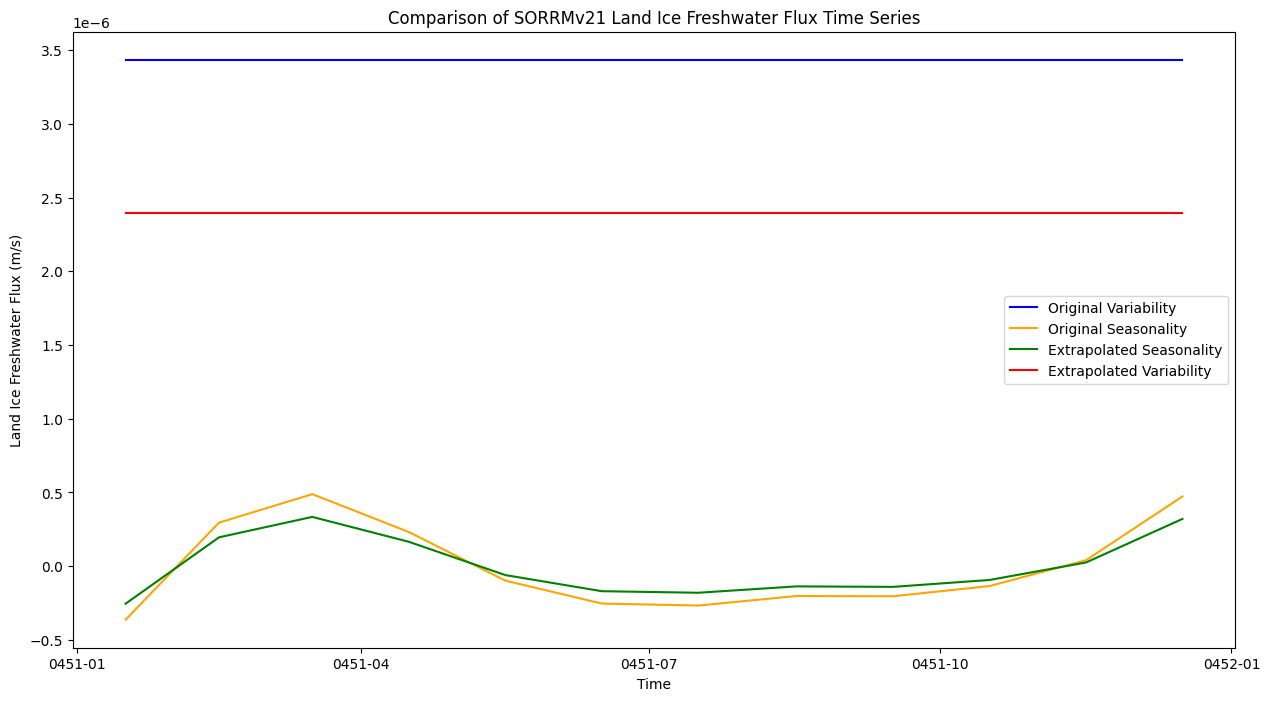

In [6]:
# Compare time series plots of the above four data variables
var_ts = var.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
ssn_ts = ssn.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
ssn_extr_ts = ssn_extr.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
var_extr_ts = var_extr.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()

plt.figure(figsize=(15,8))
var_ts.plot(label='Original Variability', color='blue')
ssn_ts.plot(label='Original Seasonality', color='orange')
ssn_extr_ts.plot(label='Extrapolated Seasonality', color='green')
var_extr_ts.plot(label='Extrapolated Variability', color='red')
plt.legend()
plt.title('Comparison of SORRMv21 Land Ice Freshwater Flux Time Series')
plt.xlabel('Time')
plt.ylabel('Land Ice Freshwater Flux (m/s)')
plt.show()


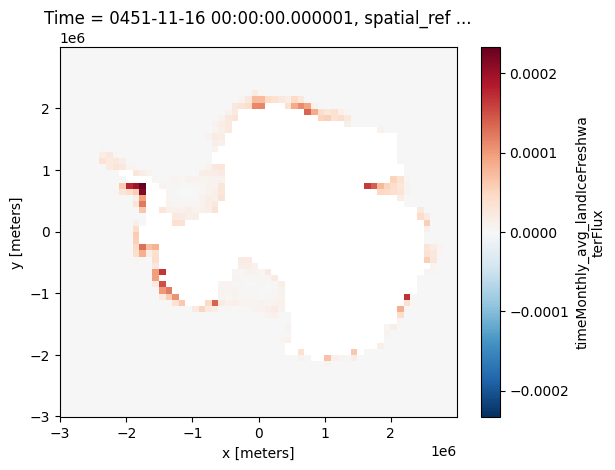

In [3]:
var.timeMonthly_avg_landIceFreshwaterFlux[10].plot()

In [10]:
# Check local files extrapolated in June 2025

var_og = xr.open_dataset(config.DIR_PROCESSED / "sorrm_variability.nc", chunks={config.TIME_DIM: 36})
ssn_og = xr.open_dataset(config.DIR_PROCESSED / "sorrm_seasonality.nc", chunks={config.TIME_DIM: 36})
var_extr_og = xr.open_dataset(config.DIR_PROCESSED / "sorrm_variability_extrapolated_fillNA_meanAdjusted.nc", chunks={config.TIME_DIM: 36})
ssn_extr_og = xr.open_dataset(config.DIR_PROCESSED / "sorrm_seasonality_extrapolated_fillNA.nc", chunks={config.TIME_DIM: 36})

# Change the variable name in ssn_og from __xarray_dataarray_variable__ to timeMonthly_avg_landIceFreshwaterFlux
ssn_og = ssn_og.rename({'__xarray_dataarray_variable__': 'timeMonthly_avg_landIceFreshwaterFlux'})

In [11]:
var_extr_og_ts = var_extr_og.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
var_og_ts = var_og.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
ssn_og_ts = ssn_og.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()
ssn_extr_og_ts = ssn_extr_og.timeMonthly_avg_landIceFreshwaterFlux.mean(dim=['x','y']).compute()

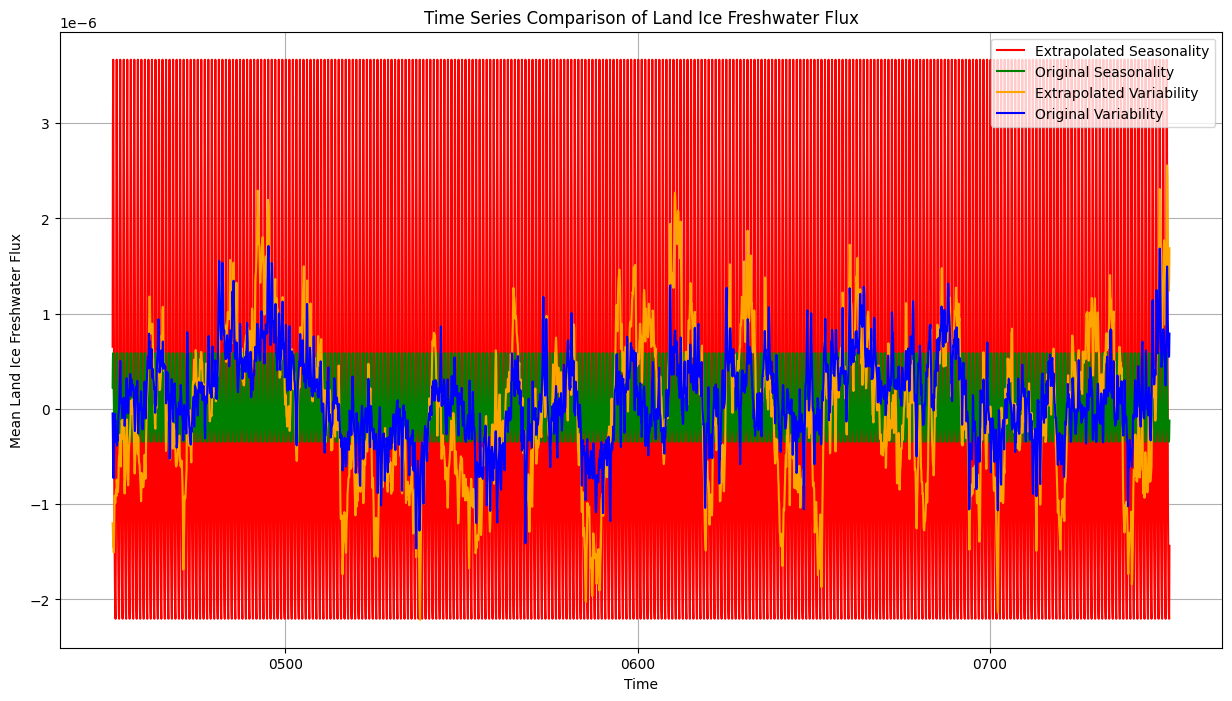

In [14]:
# Plot time series comparison
plt.figure(figsize=(15,8))
ssn_extr_og_ts.plot(label='Extrapolated Seasonality', color='red')
ssn_og_ts.plot(label='Original Seasonality', color='green')
var_extr_og_ts.plot(label='Extrapolated Variability', color='orange')
var_og_ts.plot(label='Original Variability', color='blue')
plt.title('Time Series Comparison of Land Ice Freshwater Flux')
plt.xlabel('Time')
plt.ylabel('Mean Land Ice Freshwater Flux')
plt.legend()
plt.grid()
plt.show()